 How does upset probability change as the rank gap grows? Does a 20‑spot gap differ materially from 100+?

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [38]:
df = pd.read_csv("/Users/benediktas/dev/University/data-science/tennis/tennis_atp/tennis_atpatp_matches_combined.csv")

In [39]:
ranking_df = df.dropna(subset=["winner_rank", "loser_rank"]).copy()
ranking_df.shape

(122230, 49)

In [40]:
ranking_df["better_rank_won"] = ranking_df["winner_rank"] < ranking_df["loser_rank"]
ranking_df["rank_dif"] = ranking_df["loser_rank"] - ranking_df["winner_rank"]

In [41]:
use_col = [
    "tourney_id", "tourney_name", "surface", "winner_id", "winner_name", "winner_rank", "loser_id", "loser_name", "loser_rank", "better_rank_won", "rank_dif"
]

df_for_prob = ranking_df[use_col].copy()

In [42]:
df_for_prob.head(4)

,tourney_id,tourney_name,surface,winner_id,winner_name,winner_rank,loser_id,loser_name,loser_rank,better_rank_won,rank_dif
0,1986-301,Auckland,Hard,100452,Bill Scanlon,180.0,100551,Brad Drewett,146.0,False,-34.0
1,1986-301,Auckland,Hard,101185,Mark Woodforde,127.0,100617,Bud Schultz,43.0,False,-84.0
2,1986-301,Auckland,Hard,101185,Mark Woodforde,127.0,100452,Bill Scanlon,180.0,True,53.0
3,1986-301,Auckland,Hard,100617,Bud Schultz,43.0,100923,Wally Masur,100.0,True,57.0


In [43]:
df_for_prob["upsets"] = ~df_for_prob["better_rank_won"]
df_for_prob['gap'] = df_for_prob['rank_dif'].abs()
df_for_prob.head(4)

,tourney_id,tourney_name,surface,winner_id,winner_name,winner_rank,loser_id,loser_name,loser_rank,better_rank_won,rank_dif,upsets,gap
0,1986-301,Auckland,Hard,100452,Bill Scanlon,180.0,100551,Brad Drewett,146.0,False,-34.0,True,34.0
1,1986-301,Auckland,Hard,101185,Mark Woodforde,127.0,100617,Bud Schultz,43.0,False,-84.0,True,84.0
2,1986-301,Auckland,Hard,101185,Mark Woodforde,127.0,100452,Bill Scanlon,180.0,True,53.0,False,53.0
3,1986-301,Auckland,Hard,100617,Bud Schultz,43.0,100923,Wally Masur,100.0,True,57.0,False,57.0


In [44]:
use = df_for_prob[df_for_prob["gap"] >= 0].copy()

In [45]:
bins = [0,5,10,20,40,80,120,200,1_000]
labels = ['0-5','6-10','11-20','21-40','41-80','81-120','121-200','200+']

use["gap_bin"] = pd.cut(use['gap'], bins=bins, labels=labels, include_lowest = True)

In [46]:
g = use.groupby('gap_bin')['upsets'].agg(['count', 'sum']).rename(columns={'sum':'upsets'})
g["upset_rate"] = g["upsets"] / g["count"]

g.head(10)

/var/folders/3w/c8w7npq11dl6zgnjd6gy995c0000gn/T/ipykernel_47031/3152241789.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = use.groupby('gap_bin')['upsets'].agg(['count', 'sum']).rename(columns={'sum':'upsets'})


,count,upsets,upset_rate
gap_bin,,,
0-5,8199,3868,0.471765
6-10,7728,3447,0.446040
11-20,14466,6007,0.415250
21-40,25023,9455,0.377852
41-80,30127,9834,0.326418
81-120,13805,4088,0.296125
121-200,10773,3001,0.278567
200+,11656,2595,0.222632


In [ ]:
#95% confidence of the proportion
g['se']   = np.sqrt(g['upset_rate'] * (1 - g['upset_rate']) / g['count'])
g['low95'] = (g['upset_rate'] - 1.96 * g['se']).clip(0, 1)
g['hi95']  = (g['upset_rate'] + 1.96 * g['se']).clip(0, 1)

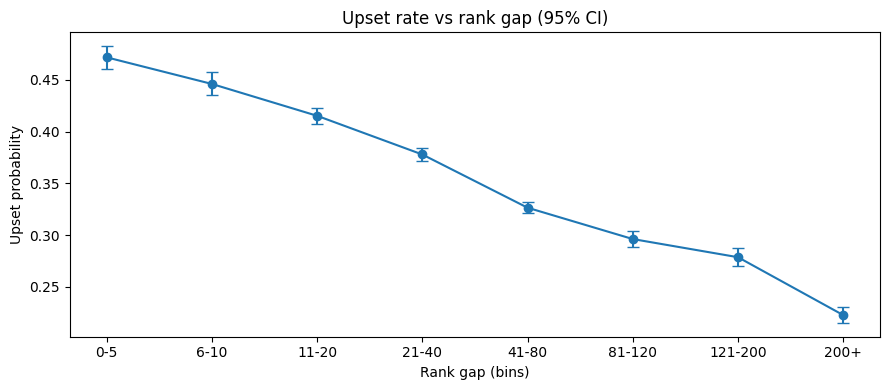

In [50]:
x = np.arange(len(g))
plt.figure(figsize=(9,4))
plt.errorbar(x, g['upset_rate'], yerr=1.96*g['se'], fmt='o-', capsize=4)
plt.xticks(x, g.index)
plt.ylabel('Upset probability')
plt.xlabel('Rank gap (bins)')
plt.title('Upset rate vs rank gap (95% CI)')
plt.tight_layout()
plt.show()